## Convolutional Neural Networks for Diabetic Retinopathy
### Pratt et Al
#### Aptos 2019 Dataset


### Setup with Dataset Download (11G)

In [ ]:
DATASET_PATH = '/content/APTOS2019'
TRAIN_PATH = DATASET_PATH + "/train_images/"
#TRAIN_PREP_PATH = DATASET_PATH + "/train_preprocessed/"

In [ ]:
!gdown --id 1nAz6IUq9OJ309bgxXLz38zbDCKXnnb4r
!unzip APTOS2019.zip

Streaming output truncated to the last 5000 lines.
  inflating: APTOS2019/train_preprocessed/484dbeb9bf2a.png  
  inflating: APTOS2019/train_preprocessed/48543037d0b3.png  
  inflating: APTOS2019/train_preprocessed/4860f7813654.png  
  inflating: APTOS2019/train_preprocessed/486e852a3b4d.png  
  inflating: APTOS2019/train_preprocessed/48a45619d1a3.png  
  inflating: APTOS2019/train_preprocessed/48afe8c47454.png  
  inflating: APTOS2019/train_preprocessed/48c49f662f7d.png  
  inflating: APTOS2019/train_preprocessed/48c72dec46e5.png  
  inflating: APTOS2019/train_preprocessed/48fda42bd5d4.png  
  inflating: APTOS2019/train_preprocessed/4926dea289f8.png  
  inflating: APTOS2019/train_preprocessed/4927945ecfed.png  
  inflating: APTOS2019/train_preprocessed/49386d603494.png  
  inflating: APTOS2019/train_preprocessed/493d99f030e2.png  
  inflating: APTOS2019/train_preprocessed/49419f8d5cb4.png  
  inflating: APTOS2019/train_preprocessed/494fc9c745a3.png  
  inflating: APTOS2019/train_prepr

### Setup with Google Drive Access

In [2]:
from google.colab import drive
import os

# Parameters
DATASET_PATH = '/content/drive/My Drive/University Of Stirling/Dissertation/PrattEtAl/APTOS2019'
TRAIN_PATH = DATASET_PATH + "/train_images/"
PREP_PATH = DATASET_PATH + "/preprocessed/"
CHECKPOINT_PATH = DATASET_PATH + "/checkpoints/"

drive.mount('/content/drive')

os.chdir(DATASET_PATH)
print("CWD:",os.getcwd())

if not os.path.exists(PREP_PATH):
  os.mkdir(PREP_PATH)

if not os.path.exists(CHECKPOINT_PATH):
  os.mkdir(CHECKPOINT_PATH)

Mounted at /content/drive
CWD: /content/drive/MyDrive/University Of Stirling/Dissertation/PrattEtAl/APTOS2019


###Imports

In [3]:
import pandas as pd
import cv2
from matplotlib import pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import theano

In [4]:
# Read Dataset
train = pd.read_csv(DATASET_PATH + "/train.csv")

### Global Parameters

In [12]:
IMG_SIZE = (512,512)
CLASSES = [ "No DR", "Mild", "Moderate", "Severe", "Proliferative DR" ]

### Preprocessing

In [5]:
# ref: https://www.kaggle.com/code/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy/notebook
# ref: https://www.kaggle.com/code/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy/notebook
# ref for circle crop: https://github.com/debayanmitra1993-data/Blindness-Detection-Diabetic-Retinopathy-/blob/master/research_paper_implementation.ipynb
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    return img 

def preprocess(id_code):

  #fig, ax = plt.subplots(1,6) 

  img = cv2.imread(TRAIN_PATH + id_code + ".png")

  #ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  #ax[0].set_title("Original") 
  #ax[0].axis('off')

  # Circle crop
  img = circle_crop(img)

  # Resize the image
  img = cv2.resize(img, IMG_SIZE)

  #ax[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  #ax[1].set_title("Circle crop and resize") 
  #ax[1].axis('off')

  # Extract Green Channel
  img[:,:,0] = 0
  img[:,:,2] = 0

  #ax[2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  #ax[2].set_title("Green Channel Extraction") 
  #ax[2].axis('off')

  # Convert to Greyscale
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  #ax[3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  #ax[3].set_title("Greyscale") 
  #ax[3].axis('off')

  # Apply Gaussian Blur
  img = cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , 512/10) ,-4 ,128)
  
  #ax[4].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  #ax[4].set_title("Gaussian Blur") 
  #ax[4].axis('off')

  # Perform histogram equalization

  clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
  img = clahe.apply(img)

  #ax[5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  #ax[5].set_title("Adaptive Histogram Equalization") 
  #ax[5].axis('off')

  cv2.imwrite(PREP_PATH + id_code + ".png", img)


#preprocess("0dc8d25b3f69") # Level 3

for id_code in train["id_code"]:
  preprocess(id_code) 

In [ ]:
if not os.path.exists(DATASET_PATH + "/train"):
  os.mkdir(DATASET_PATH + "/train")
  os.mkdir(DATASET_PATH + "/train/0")
  os.mkdir(DATASET_PATH + "/train/1")
  os.mkdir(DATASET_PATH + "/train/2")
  os.mkdir(DATASET_PATH + "/train/3")
  os.mkdir(DATASET_PATH + "/train/4")

if not os.path.exists(DATASET_PATH + "/validation"):
  os.mkdir(DATASET_PATH + "/validation")
  os.mkdir(DATASET_PATH + "/validation/0")
  os.mkdir(DATASET_PATH + "/validation/1")
  os.mkdir(DATASET_PATH + "/validation/2")
  os.mkdir(DATASET_PATH + "/validation/3")
  os.mkdir(DATASET_PATH + "/validation/4")

if not os.path.exists(DATASET_PATH + "/test"):
  os.mkdir(DATASET_PATH + "/test")
  os.mkdir(DATASET_PATH + "/test/0")
  os.mkdir(DATASET_PATH + "/test/1")
  os.mkdir(DATASET_PATH + "/test/2")
  os.mkdir(DATASET_PATH + "/test/3")
  os.mkdir(DATASET_PATH + "/test/4")

In [ ]:
from sklearn.model_selection import train_test_split
import shutil

def read_dataset():
  df = pd.read_csv(DATASET_PATH + "/train.csv")
  
  # Train-test split
  train, test = train_test_split(df, test_size=.2)
  train, valid = train_test_split(train, test_size=.3)

  for image in train.values:
    shutil.copyfile(PREP_PATH + image[0] + ".png", DATASET_PATH + "/train/" + str(image[1]) + "/" + image[0] + ".png")

  for image in valid.values:
    shutil.copyfile(PREP_PATH + image[0] + ".png", DATASET_PATH + "/validation/" + str(image[1]) + "/" + image[0] + ".png")

  for image in test.values:
    shutil.copyfile(PREP_PATH + image[0] + ".png", DATASET_PATH + "/test/" + str(image[1]) + "/" + image[0] + ".png")
  
  return (train, valid, test)


train, valid, test = read_dataset()

print(train.shape, valid.shape, test.shape)

### Training

In [9]:
from sklearn.utils import compute_class_weight
from tensorflow.keras import regularizers

def create_model():
  return keras.models.Sequential([
    keras.layers.Dense(3, kernel_initializer= keras.initializers.random_normal),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides = (2,2), activation=keras.layers.LeakyReLU(alpha=0.01), bias_regularizer=regularizers.L2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides = (2,2), activation=keras.layers.LeakyReLU(alpha=0.01), padding="same", bias_regularizer=regularizers.L2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), padding='same'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides = (2,2), activation=keras.layers.LeakyReLU(alpha=0.01), padding="same", bias_regularizer=regularizers.L2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), padding='same'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides = (2,2), activation=keras.layers.LeakyReLU(alpha=0.01), padding="same", bias_regularizer=regularizers.L2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), padding='same'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides = (2,2), activation=keras.layers.LeakyReLU(alpha=0.01), padding="same", bias_regularizer=regularizers.L2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'), 
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides = (2,2), activation=keras.layers.LeakyReLU(alpha=0.01), padding="same", bias_regularizer=regularizers.L2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'), 
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides = (2,2), activation=keras.layers.LeakyReLU(alpha=0.01), padding="same", bias_regularizer=regularizers.L2(0.01)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides = (2,2), activation=keras.layers.LeakyReLU(alpha=0.01), padding="same", bias_regularizer=regularizers.L2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides = (2,2), activation=keras.layers.LeakyReLU(alpha=0.01), padding="same", bias_regularizer=regularizers.L2(0.01)),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides = (2,2), activation=keras.layers.LeakyReLU(alpha=0.01), padding="same", bias_regularizer=regularizers.L2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation=keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation=keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5,activation='softmax')  
  ])
  
model = create_model()
model.build(input_shape=(32,512,512,3))
model.summary()

# create a data generator
datagen = ImageDataGenerator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (32, 512, 512, 3)         12        
                                                                 
 conv2d_10 (Conv2D)          (32, 255, 255, 32)        896       
                                                                 
 batch_normalization_8 (Batc  (32, 255, 255, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (32, 128, 128, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (32, 64, 64, 32)          9248      
                                                                 
 batch_normalization_9 (Batc  (32, 64, 64, 32)        

In [5]:
# load and iterate training dataset
train_it = datagen.flow_from_directory(DATASET_PATH + "/train/", class_mode='categorical', batch_size=32, target_size=IMG_SIZE)
valid_it = datagen.flow_from_directory(DATASET_PATH + "/validation/", class_mode='categorical', batch_size=32, target_size=IMG_SIZE, shuffle=False)

# Address class imbalance for the training set
class_weights = compute_class_weight('balanced', classes = np.unique(train.loc[:,"diagnosis"]), y = train.loc[:,"diagnosis"])
class_weight = {i : class_weights[i] for i in range(5)}
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.8, nesterov=True, name="SGD")


# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=["accuracy"])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(train_it, validation_data=valid_it, epochs=5, class_weight=class_weight, callbacks=[model_checkpoint_callback], verbose=1)

Found 2050 images belonging to 5 classes.
Found 879 images belonging to 5 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (32, 512, 512, 3)         12        
                                                                 
 conv2d (Conv2D)             (32, 255, 255, 32)        896       
                                                                 
 batch_normalization (BatchN  (32, 255, 255, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (32, 128, 128, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 64, 64, 32)          9248      
                                       

In [6]:
from keras import layers

for layer in model.layers:
    layer.trainable = True

# ImageDataGenerator
datagen_augmented = ImageDataGenerator(
  rotation_range=90, 
  width_shift_range=0.2, 
  height_shift_range=0.2, 
  horizontal_flip=True,
  vertical_flip = True)

# load and iterate training dataset
train_it = datagen.flow_from_directory(DATASET_PATH + "/train/", class_mode='categorical', batch_size=32, target_size=IMG_SIZE)

#model.load_model(CHECKPOINT_PATH + "saved_model.pb")
model.load_weights(CHECKPOINT_PATH)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.0003, momentum=0.8, nesterov=True, name="SGD")

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=["accuracy"])

history_full = model.fit(train_it, validation_data=valid_it, epochs=120, class_weight=class_weight, callbacks=[model_checkpoint_callback], verbose=1).history

Found 2050 images belonging to 5 classes.
Epoch 1/120
65/65 [==============================] - 26s 373ms/step - loss: 1.7825 - accuracy: 0.2127 - val_loss: 1.6142 - val_accuracy: 0.0557
Epoch 2/120
65/65 [==============================] - 24s 365ms/step - loss: 1.7371 - accuracy: 0.2717 - val_loss: 1.6143 - val_accuracy: 0.0660
Epoch 3/120
65/65 [==============================] - 25s 380ms/step - loss: 1.6980 - accuracy: 0.2956 - val_loss: 1.6133 - val_accuracy: 0.1263
Epoch 4/120
65/65 [==============================] - 25s 375ms/step - loss: 1.6386 - accuracy: 0.3371 - val_loss: 1.5997 - val_accuracy: 0.4585
Epoch 5/120
65/65 [==============================] - 24s 370ms/step - loss: 1.5466 - accuracy: 0.4205 - val_loss: 1.5820 - val_accuracy: 0.4448
Epoch 6/120
65/65 [==============================] - 24s 372ms/step - loss: 1.4936 - accuracy: 0.4561 - val_loss: 1.4364 - val_accuracy: 0.4755
Epoch 7/120
65/65 [==============================] - 24s 372ms/step - loss: 1.4590 - accuracy:

Found 733 images belonging to 5 classes.
23/23 [==============================] - 4s 190ms/step - loss: 4.8649 - accuracy: 0.3179
4.86490535736084 0.31787174940109253


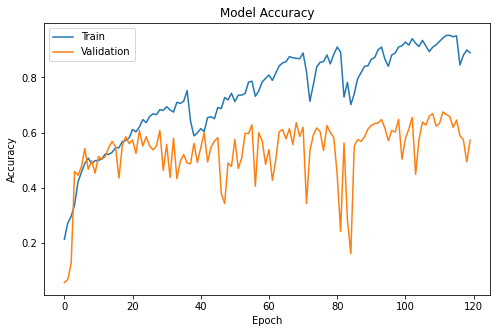

In [7]:
test_it = datagen.flow_from_directory(DATASET_PATH + "/test/", class_mode='categorical', batch_size=32, shuffle = False)

model.load_weights(CHECKPOINT_PATH)
predictions = model.predict(test_it)
loss, acc = model.evaluate(test_it, verbose=1)
print(loss,acc)

plt.figure(figsize=(8,5))

plt.plot(history_full['accuracy'])
plt.plot(history_full['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

### Explainability

In [65]:
#https://stackoverflow.com/questions/66182884/how-to-implement-grad-cam-on-a-trained-network
#
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

1
(200, 200) (200, 200, 3)


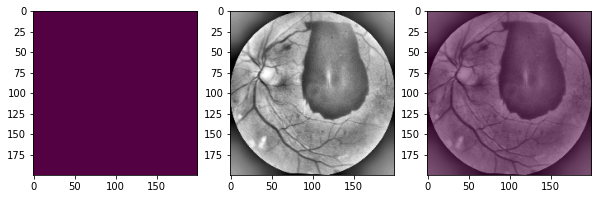

In [82]:

img_path = DATASET_PATH + "/test/4/55eb405ec71e.png"

image = cv2.imread(img_path)
image = image.astype('float32') / 255

image = np.expand_dims(image, axis=0)
preds = model.predict(image) 
i = np.argmax(preds[0])
print(i)

#conv2d_19

icam = GradCAM(model, i, 'conv2d_19') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (200, 200))

image = cv2.imread(img_path)
image = cv2.resize(image, (200, 200))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)


plt.rcParams["figure.figsize"] = (10,10)

fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)